In [1]:
import numpy as np
import os
import torch
import lovely_tensors as lt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from PIL import Image

import torchvision.transforms.functional as TF

lt.monkey_patch()

In [2]:
from model import Generator

gen = Generator()

checkpoint = "runs/celestial-river-3/gen_02500.pt"
gen.load_state_dict(torch.load(checkpoint))
gen = gen.eval().cuda()

In [3]:
from torchvision import transforms
from PIL import Image

transform = transforms.Compose(
    [
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ]
)

In [4]:
def approximate_gen_seed(real_image, save_evolution=False):
    x = torch.normal(0, 1, [1, gen.fc.in_features]).cuda()

    criterion = nn.HuberLoss(delta=0.1)
    optimizer = optim.SGD([x.requires_grad_()], lr=0.5, momentum=0.9)

    image_evolution = []

    for step in range(10000):
        optimizer.zero_grad()
        fake_image = gen(x)

        if step % 100 == 0 and save_evolution:
            image_evolution.append(fake_image.squeeze(0).detach().clone())

        loss = criterion(fake_image, real_image)
        loss.backward()
        print(f"step={step:06d} loss={loss.item():.4f}", end=" " * 10 + "\r")
        optimizer.step()

    if save_evolution:
        image_evolution = [(im + 1) / 2 for im in image_evolution]
        image_evolution = [TF.to_pil_image(im) for im in image_evolution]

        os.makedirs("generated_imgs/evolution", exist_ok=True)
        for i, im in enumerate(image_evolution):
            im.save(f"generated_imgs/evolution/{i:05d}.jpg")

    return x

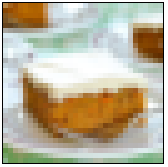

In [5]:
real_image_1 = transform(Image.open("dataset/crawled_cakes/015_a1ac77f0.jpg")).cuda().unsqueeze(0)
(real_image_1 / 2 + 0.5).rgb(scale=5)

In [6]:
x_1 = approximate_gen_seed(real_image_1, save_evolution=True)
x_1

tensor[1, 64] x∈[-4.566, 4.058] μ=-0.127 σ=1.971 grad cuda:0

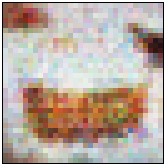

In [7]:
fake_image_1 = gen(x_1)
(fake_image_1 / 2 + 0.5).rgb(scale=5)

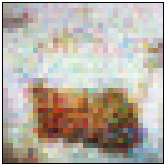

In [8]:
x_1_modified = x_1.detach()
x_1_modified[0, 0] = 10
x_1_modified[0, 1] = -5
x_1_modified[0, 2] = 0

img = gen(x_1_modified)
(img / 2 + 0.5).rgb(scale=5)

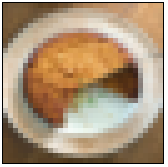

In [9]:
real_image_2 = transform(Image.open("dataset/crawled_cakes/981_bb56bb77.jpg")).cuda().unsqueeze(0)
(real_image_2 / 2 + 0.5).rgb(scale=5)

In [10]:
x_2 = approximate_gen_seed(real_image_2)
x_2

tensor[1, 64] x∈[-4.972, 2.827] μ=-0.402 σ=1.615 grad cuda:0

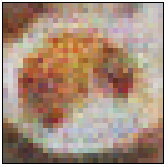

In [11]:
fake_image_2 = gen(x_2)
(fake_image_2 / 2 + 0.5).rgb(scale=5)

In [12]:
x_1_2 = [torch.linspace(a.item(), b.item(), 100) for a, b in zip(x_1[0], x_2[0])]
x_1_2 = torch.stack(x_1_2, dim=1).cuda()
transition = gen(x_1_2)
transition = [TF.to_pil_image(f / 2 + 0.5) for f in transition]

In [13]:
os.makedirs("generated_imgs/transition", exist_ok=True)
for i, im in enumerate(transition):
    im.save(f"generated_imgs/transition/{i:05d}.jpg")

In [14]:
%run create_gif.py generated_imgs/transition -o transition.gif

GIF saved as transition.gif
